# Build mutliclass classification models where some use RFE selected features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from itertools import cycle
from sklearn.model_selection import train_test_split 
from sklearn.metrics import log_loss

In [2]:
# Drop first column of dataframe
def drop_first_col(df):
    return df.iloc[: , 1:]

X_train_20 = pd.read_csv("dataset\X_train_3_20.csv")
X_test_20 = pd.read_csv("dataset\X_test_3_20.csv")
y_train_20 = pd.read_csv("dataset\y_train_3_20.csv")
y_test_20 = pd.read_csv("dataset\y_test_3_20.csv")

X_train_40 = pd.read_csv("dataset\X_train_3_40.csv")
X_test_40 = pd.read_csv("dataset\X_test_3_40.csv")
y_train_40 = pd.read_csv("dataset\y_train_3_40.csv")
y_test_40 = pd.read_csv("dataset\y_test_3_40.csv")

X_train_20 = drop_first_col(X_train_20)
X_test_20 = drop_first_col(X_test_20)
y_train_20 = drop_first_col(y_train_20)
y_test_20 = drop_first_col(y_test_20)

X_train_40 = drop_first_col(X_train_40)
X_test_40 = drop_first_col(X_test_40)
y_train_40 = drop_first_col(y_train_40)
y_test_40 = drop_first_col(y_test_40)

## Test on single commonly used models

### XGB Classifier (with no hyperparameters selection) for multi-class

In [3]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False,objective='multi:softproba')
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False,objective='multi:softproba')

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))
    
    y_test = label_binarize(y_test, classes=np.arange(3))
    y_predicted = label_binarize(y_predicted, classes=np.arange(3))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("AUC =",roc_auc)
    
    return clf.predict_proba(X_test)

In [7]:
XGBc_y_predicted_20 = XGB_class(X_train_20,X_test_20,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)
XGBc_y_predicted_40 = XGB_class(X_train_40,X_test_40,y_train_40,y_test_40,0,0,0,0,0,0,0,simple=True)

              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.70      0.70      0.70        10
           2       0.50      0.38      0.43         8

    accuracy                           0.56        27
   macro avg       0.55      0.54      0.54        27
weighted avg       0.56      0.56      0.55        27

Accuracy: 0.5555555555555556
MCC = 0.3305699764271252
AUC = {0: 0.6111111111111112, 1: 0.7617647058823529, 2: 0.6085526315789473}
              precision    recall  f1-score   support

           0       0.29      0.32      0.30        19
           1       0.42      0.55      0.48        20
           2       0.43      0.20      0.27        15

    accuracy                           0.37        54
   macro avg       0.38      0.36      0.35        54
weighted avg       0.38      0.37      0.36        54

Accuracy: 0.37037037037037035
MCC = 0.03047125546029282
AUC = {0: 0.44360902255639095, 1: 0.5544117647058824

### SVM

In [4]:
def SVMc(X_train,X_test,y_train,y_test):
    clf = svm.SVC(kernel='poly',probability=True).fit(X_train, y_train)

    preds = clf.predict(X_test)
    sSVM_y_predicted = clf.predict_proba(X_test)
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    
    y_test = label_binarize(y_test, classes=np.arange(3))
    y_predicted = label_binarize(preds, classes=np.arange(3))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("AUC =",roc_auc)
    
    return sSVM_y_predicted

In [9]:
print('Using 20% as test subset:')
SVM_y_predicted_20 = SVMc(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
SVM_y_predicted_40 = SVMc(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.71      1.00      0.83        10
           2       0.67      0.50      0.57         8

    accuracy                           0.67        27
   macro avg       0.65      0.65      0.63        27
weighted avg       0.65      0.67      0.64        27

Accuracy: 0.6666666666666666
MCC = 0.5046684724839113
AUC = {0: 0.6388888888888888, 1: 0.8823529411764706, 2: 0.6973684210526315}
Using 40% as test subset:
              precision    recall  f1-score   support

           0       0.44      0.42      0.43        19
           1       0.64      0.80      0.71        20
           2       0.36      0.27      0.31        15

    accuracy                           0.52        54
   macro avg       0.48      0.50      0.48        54
weighted avg       0.49      0.52      0.50        54

Accuracy: 0.5185185185185185
MCC = 0.26754502228372407
A

C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Random Forest classifier  for multi-class

In [18]:
def RFc(X_train,X_test,y_train,y_test):
    model = RandomForestClassifier().fit(X_train,y_train)
    preds = model.predict(X_test)
    sRFC_y_predicted = model.predict_proba(X_test)
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    
    y_test = label_binarize(y_test, classes=np.arange(3))
    y_predicted = label_binarize(preds, classes=np.arange(3))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("AUC =",roc_auc)
    
    return sRFC_y_predicted

In [11]:
print('Using 20% as test subset:')
RFc_y_predicted_20 = RFc(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
RFc_y_predicted420 = RFc(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

           0       0.33      0.44      0.38         9
           1       0.58      0.70      0.64        10
           2       0.67      0.25      0.36         8

    accuracy                           0.48        27
   macro avg       0.53      0.46      0.46        27
weighted avg       0.52      0.48      0.47        27

Accuracy: 0.48148148148148145
MCC = 0.21650635094610965
AUC = {0: 0.5, 1: 0.7029411764705882, 2: 0.5986842105263158}
Using 40% as test subset:


C:\Users\marti\AppData\Local\Temp\ipykernel_14208\3052431571.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier().fit(X_train,y_train)
C:\Users\marti\AppData\Local\Temp\ipykernel_14208\3052431571.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier().fit(X_train,y_train)


              precision    recall  f1-score   support

           0       0.22      0.21      0.22        19
           1       0.42      0.65      0.51        20
           2       0.60      0.20      0.30        15

    accuracy                           0.37        54
   macro avg       0.41      0.35      0.34        54
weighted avg       0.40      0.37      0.35        54

Accuracy: 0.37037037037037035
MCC = 0.024424013458612084
AUC = {0: 0.4052631578947368, 1: 0.5602941176470588, 2: 0.5743589743589743}


### Logistic Regression for multi-class

In [19]:
def LR(X_train,X_test,y_train,y_test):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train,y_train)
    preds = model.predict(X_test)
    sLR_y_predicted = model.predict_proba(X_test)
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    
    y_test = label_binarize(y_test, classes=np.arange(3))
    y_predicted = label_binarize(preds, classes=np.arange(3))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("AUC =",roc_auc)
    
    return sLR_y_predicted

In [8]:
print('Using 20% as test subset:')
LR_y_predicted_20 = LR(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
LR_y_predicted_40 = LR(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.69      0.90      0.78        10
           2       0.71      0.62      0.67         8

    accuracy                           0.67        27
   macro avg       0.66      0.66      0.65        27
weighted avg       0.66      0.67      0.65        27

Accuracy: 0.6666666666666666
MCC = 0.5011926315100854
AUC = {0: 0.6388888888888888, 1: 0.8323529411764704, 2: 0.7598684210526316}
Using 40% as test subset:
              precision    recall  f1-score   support

           0       0.53      0.47      0.50        19
           1       0.63      0.85      0.72        20
           2       0.50      0.33      0.40        15

    accuracy                           0.57        54
   macro avg       0.55      0.55      0.54        54
weighted avg       0.56      0.57      0.55        54

Accuracy: 0.5740740740740741
MCC = 0.35483623400235725
A

C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

## Features Selection techniques

### Recursive Feature Elimination (RFE) -> backward feature selection

In [5]:
def rfe_xgb(X_train, y_train,X_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    min_features_to_select = 1
    
    #run RFE on current train subset
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)
    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])
    
    return newX_train,newX_test

### Test on XGB classifier using RFE selected features for multi-class

In [15]:
#test rfe then simple XGB classifier
newX_train,newX_test = rfe_xgb(X_train_20, y_train_20,X_test_20,0,0,0,0,0,0,0,simple=True)
RFE_XGB_y_predicted_20 = XGB_class(newX_train,newX_test,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)

We kept 71 features out of the 320
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.50      0.40      0.44        10
           2       0.38      0.38      0.38         8

    accuracy                           0.44        27
   macro avg       0.44      0.44      0.44        27
weighted avg       0.45      0.44      0.44        27

Accuracy: 0.4444444444444444
MCC = 0.1680512392345396
AUC = {0: 0.6111111111111112, 1: 0.5823529411764705, 2: 0.555921052631579}


In [6]:
#test rfe then simple XGB classifier
newX_train,newX_test = rfe_xgb(X_train_40, y_train_40,X_test_40,0,0,0,0,0,0,0,simple=True)
RFE_XGB_y_predicted_40 = XGB_class(newX_train,newX_test,y_train_40,y_test_40,0,0,0,0,0,0,0,simple=True)

We kept 110 features out of the 320
              precision    recall  f1-score   support

           0       0.37      0.37      0.37        19
           1       0.41      0.55      0.47        20
           2       0.50      0.27      0.35        15

    accuracy                           0.41        54
   macro avg       0.43      0.40      0.39        54
weighted avg       0.42      0.41      0.40        54

Accuracy: 0.4074074074074074
MCC = 0.09055967695009846
AUC = {0: 0.512781954887218, 1: 0.5397058823529413, 2: 0.582051282051282}


### Test on SVM classifier using RFE selected features for multi-class

In [7]:
def rfe_SVM(X_train, y_train,X_test):
    min_features_to_select = 1

    #run RFE on current train subset
    clf = SVC(kernel='linear',probability=True) 

    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train.values.ravel())

    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])

    return newX_train,newX_test

In [8]:
#test rfe then SVM classifier
newX_train,newX_test = rfe_SVM(X_train_20, y_train_20,X_test_20)
RFE_SVM_y_predicted_20 = SVMc(newX_train,newX_test,y_train_20,y_test_20)

We kept 56 features out of the 320
              precision    recall  f1-score   support

           0       0.38      0.33      0.35         9
           1       0.75      0.90      0.82        10
           2       0.57      0.50      0.53         8

    accuracy                           0.59        27
   macro avg       0.57      0.58      0.57        27
weighted avg       0.57      0.59      0.58        27

Accuracy: 0.5925925925925926
MCC = 0.3849675674847534
AUC = {0: 0.5277777777777778, 1: 0.8617647058823529, 2: 0.6710526315789473}


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
#test rfe then SVM classifier
newX_train,newX_test = rfe_SVM(X_train_40, y_train_40,X_test_40)
RFE_SVM_y_predicted_40 = SVMc(newX_train,newX_test,y_train_40,y_test_40)

We kept 68 features out of the 320
              precision    recall  f1-score   support

           0       0.35      0.37      0.36        19
           1       0.64      0.70      0.67        20
           2       0.25      0.20      0.22        15

    accuracy                           0.44        54
   macro avg       0.41      0.42      0.42        54
weighted avg       0.43      0.44      0.43        54

Accuracy: 0.4444444444444444
MCC = 0.15506438519186494
AUC = {0: 0.49849624060150377, 1: 0.7323529411764705, 2: 0.48461538461538456}


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Test on RF classifier using RFE selected features for multi-class

In [16]:
def rfe_RFc(X_train, y_train,X_test):
    min_features_to_select = 1

    #run RFE on current train subset
    clf = RandomForestClassifier().fit(X_train,y_train)

    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train.values.ravel())

    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])

    return newX_train,newX_test

In [23]:
print("20 %")
newX_train,newX_test = rfe_RFc(X_train_20, y_train_20,X_test_20)
RFE_RFc_y_predicted_20 = RFc(newX_train,newX_test,y_train_20,y_test_20)
print("40 %")
newX_train,newX_test = rfe_RFc(X_train_40, y_train_40,X_test_40)
RFE_RFc_y_predicted_40 = RFc(newX_train,newX_test,y_train_40,y_test_40)

20 %


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

We kept 77 features out of the 320
              precision    recall  f1-score   support

           0       0.27      0.33      0.30         9
           1       0.58      0.70      0.64        10
           2       0.50      0.25      0.33         8

    accuracy                           0.44        27
   macro avg       0.45      0.43      0.42        27
weighted avg       0.46      0.44      0.43        27

Accuracy: 0.4444444444444444
MCC = 0.1567693552822363
AUC = {0: 0.4444444444444444, 1: 0.7029411764705882, 2: 0.5723684210526316}
40 %


C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

We kept 320 features out of the 320
              precision    recall  f1-score   support

           0       0.35      0.32      0.33        19
           1       0.43      0.65      0.52        20
           2       0.57      0.27      0.36        15

    accuracy                           0.43        54
   macro avg       0.45      0.41      0.41        54
weighted avg       0.44      0.43      0.41        54

Accuracy: 0.42592592592592593
MCC = 0.11891568463930174
AUC = {0: 0.5007518796992482, 1: 0.575, 2: 0.5948717948717949}


### Test on LR classifier using RFE selected features for multi-class

In [21]:
def rfe_RFc(X_train, y_train,X_test):
    min_features_to_select = 1

    #run RFE on current train subset
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train,y_train)


    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train.values.ravel())

    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])

    return newX_train,newX_test

In [22]:
print("20 %")
newX_train,newX_test = rfe_SVM(X_train_20, y_train_20,X_test_20)
RFE_LR_y_predicted_20 = SVMc(newX_train,newX_test,y_train_20,y_test_20)
print("40 %")
newX_train,newX_test = rfe_SVM(X_train_40, y_train_40,X_test_40)
RFE_LR_y_predicted_40 = SVMc(newX_train,newX_test,y_train_40,y_test_40)

20 %
We kept 56 features out of the 320
              precision    recall  f1-score   support

           0       0.38      0.33      0.35         9
           1       0.75      0.90      0.82        10
           2       0.57      0.50      0.53         8

    accuracy                           0.59        27
   macro avg       0.57      0.58      0.57        27
weighted avg       0.57      0.59      0.58        27

Accuracy: 0.5925925925925926
MCC = 0.3849675674847534
AUC = {0: 0.5277777777777778, 1: 0.8617647058823529, 2: 0.6710526315789473}
40 %


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


We kept 68 features out of the 320
              precision    recall  f1-score   support

           0       0.35      0.37      0.36        19
           1       0.64      0.70      0.67        20
           2       0.25      0.20      0.22        15

    accuracy                           0.44        54
   macro avg       0.41      0.42      0.42        54
weighted avg       0.43      0.44      0.43        54

Accuracy: 0.4444444444444444
MCC = 0.15506438519186494
AUC = {0: 0.49849624060150377, 1: 0.7323529411764705, 2: 0.48461538461538456}


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Plot AUC-ROC Curve

In [5]:
def single_row(y_test,y_predicted,title):
    y_test = label_binarize(y_test, classes=np.arange(3))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    labels=['slow','rapid','stable']
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(labels[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

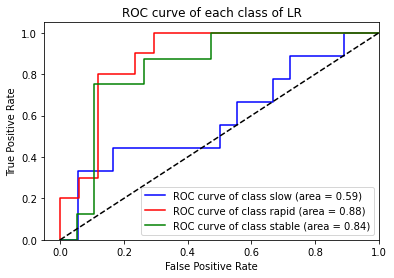

In [10]:
title = 'ROC curve of each class of LR'
single_row(y_test_20,LR_y_predicted_20,title)

### FORWARD ORDER using forward feature selection (Greedy Feature Selection Algorithm)

In [10]:
def forward_select(X_train, y_train):
    
    acc_imp = 0  
    last_best_acc=1000
    features_selected=[]
    best_features = []
    no_imp_counter=0
    
    while no_imp_counter<20:
        accuracies = []
        for i in range(len(X_train)):   
            curr_X_train = X_train.iloc[:,i]
            for j in range(len(features_selected)):
                curr_X_train = pd.concat([curr_X_train, features_selected[j]],axis=1)
            fs_X_train, fs_X_test, fs_y_train, fs_y_test = train_test_split(curr_X_train, y_train, test_size = 0.80, random_state = 97,stratify=y_train)

            clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False,objective='multi:softproba')
            clf.fit(fs_X_train, fs_y_train)
            y_predicted = clf.predict_proba(fs_X_test)
            accuracies.append(log_loss(fs_y_test, y_predicted))
        
        best_feature_idx=np.argmin(accuracies) 
        print('new best feature added =',X_train.iloc[:,best_feature_idx].name)
        features_selected.append(X_train.iloc[:,best_feature_idx])
        X_train.drop(X_train.columns[best_feature_idx],axis=1,inplace=True)
        
        curr_acc=accuracies[best_feature_idx]
        print('new log loss =',curr_acc)
        if curr_acc<last_best_acc:
            acc_imp = last_best_acc-curr_acc
            last_best_acc = curr_acc
            best_features=features_selected.copy()
            no_imp_counter=0
            print('improvement of',acc_imp,'\n')
        else:
            no_imp_counter+=1
            print('no improvement for',no_imp_counter,'times \n')

    
    print('-> last best log loss on training set =',last_best_acc)
    
    best_features_names = []
    for i in best_features:
        best_features_names.append(i.name)

    return best_features_names

In [19]:
#test tuning XGB hyperparameters with selected features from forward selection
print('1) Forward feature selection:')
fs_best_features = forward_select(X_train_20.copy(), y_train_20)
newX_train = X_train_20.loc[:,fs_best_features]
newX_test = X_test_20[(newX_train.columns) & (X_test_20.columns)]
print('We kept',newX_train.shape[1],'features out of the',X_train_20.shape[1])
print('2) XGB with forward feature selection')
XGB_class(newX_train,newX_test,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)

1) Forward feature selection:
new best feature added = CATD.YSQAVPAVTEGPIPEVLK
new log loss = 1.342066453534296
improvement of 998.6579335464658 

new best feature added = CNTN2.IIVQAQPEWLK
new log loss = 1.2342850686232933
improvement of 0.10778138491100275 

new best feature added = CFAB.YGLVTYATYPK
new log loss = 1.1350263081191259
improvement of 0.09925876050416749 

new best feature added = CNDP1.ALEQDLPVNIK
new log loss = 1.0735944995078548
improvement of 0.061431808611271066 

new best feature added = CMGA.SGELEQEEER
new log loss = 1.0482630591368538
improvement of 0.02533144037100099 

new best feature added = AATC.LALGDDSPALK
new log loss = 1.0662149140803978
no improvement for 1 times 

new best feature added = CH3L1.VTIDSSYDIAK
new log loss = 1.0158008875689288
improvement of 0.03246217156792497 

new best feature added = CMGA.SGEATDGARPQALPEPMQESK
new log loss = 1.0111668634003605
improvement of 0.004634024168568285 

new best feature added = CO4A.VTASDPLDTLGSEGALSPGGVASLLR

C:\Users\marti\AppData\Local\Temp\ipykernel_14208\48801181.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  newX_test = X_test_20[(newX_train.columns) & (X_test_20.columns)]


array([[0.8981927 , 0.04257743, 0.0592299 ],
       [0.04032784, 0.93813324, 0.02153898],
       [0.11148787, 0.10848126, 0.78003085],
       [0.38181877, 0.18956146, 0.4286198 ],
       [0.00566998, 0.98815453, 0.00617543],
       [0.7493525 , 0.07113768, 0.17950982],
       [0.0809505 , 0.8244039 , 0.09464566],
       [0.8819124 , 0.03138743, 0.08670016],
       [0.7628539 , 0.23414762, 0.00299845],
       [0.10695112, 0.12006779, 0.7729811 ],
       [0.9911646 , 0.00618158, 0.00265379],
       [0.1028212 , 0.8620408 , 0.03513798],
       [0.26013115, 0.62074155, 0.11912728],
       [0.8553514 , 0.08178139, 0.06286719],
       [0.10611061, 0.509487  , 0.3844024 ],
       [0.282826  , 0.582155  , 0.13501902],
       [0.1457948 , 0.23695537, 0.61724985],
       [0.00796282, 0.7832039 , 0.20883326],
       [0.41502237, 0.22214872, 0.36282888],
       [0.08900953, 0.22671291, 0.6842776 ],
       [0.03038352, 0.9486815 , 0.02093503],
       [0.63474953, 0.15976182, 0.20548865],
       [0.

In [11]:
#test tuning XGB hyperparameters with selected features from forward selection
print('1) Forward feature selection:')
fs_best_features = forward_select(X_train_40.copy(), y_train_40)
newX_train = X_train_40.loc[:,fs_best_features]
newX_test = X_test_40[(newX_train.columns) & (X_test_40.columns)]
print('We kept',newX_train.shape[1],'features out of the',X_train_40.shape[1])
print('2) XGB with forward feature selection')
XGB_class(newX_train,newX_test,y_train_40,y_test_40,0,0,0,0,0,0,0,simple=True)

1) Forward feature selection:
new best feature added = APLP2.HYQHVLAVDPEK
new log loss = 1.359009668460259
improvement of 998.6409903315398 

new best feature added = CFAB.DAQYAPGYDK
new log loss = 1.3320168717549397
improvement of 0.0269927967053194 

new best feature added = APOE.LAVYQAGAR
new log loss = 1.2031554226691907
improvement of 0.12886144908574892 

new best feature added = A1BG.SGLSTGWTQLSK
new log loss = 1.152985826593179
improvement of 0.05016959607601179 

new best feature added = A1BG.NGVAQEPVHLDSPAIK
new log loss = 1.1275840367835301
improvement of 0.0254017898096488 

new best feature added = BASP1.ETPAATEAPSSTPK
new log loss = 1.1503074237360404
no improvement for 1 times 

new best feature added = B3GN1.TALASGGVLDASGDYR
new log loss = 1.1600045345150507
no improvement for 2 times 

new best feature added = ALDOA.ALQASALK
new log loss = 1.1316222896656165
no improvement for 3 times 

new best feature added = A1AT.AVLTIDEK
new log loss = 1.0452849538280413
improvemen

C:\Users\marti\AppData\Local\Temp\ipykernel_20772\1462326117.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  newX_test = X_test_40[(newX_train.columns) & (X_test_40.columns)]


We kept 30 features out of the 320
2) XGB with forward feature selection
              precision    recall  f1-score   support

           0       0.25      0.32      0.28        19
           1       0.41      0.45      0.43        20
           2       0.25      0.13      0.17        15

    accuracy                           0.31        54
   macro avg       0.30      0.30      0.29        54
weighted avg       0.31      0.31      0.31        54

Accuracy: 0.3148148148148148
MCC = -0.05269609319809172
AUC = {0: 0.4007518796992482, 1: 0.5338235294117647, 2: 0.4897435897435897}


array([[0.01335126, 0.9810296 , 0.00561906],
       [0.5538356 , 0.38455567, 0.0616088 ],
       [0.16249552, 0.7936623 , 0.04384219],
       [0.9016113 , 0.05470495, 0.04368374],
       [0.08770977, 0.37356755, 0.5387227 ],
       [0.0092732 , 0.9253433 , 0.06538352],
       [0.3786369 , 0.32308802, 0.29827505],
       [0.6426644 , 0.31161636, 0.0457193 ],
       [0.46612796, 0.5099951 , 0.02387691],
       [0.23158817, 0.0589674 , 0.7094444 ],
       [0.17444102, 0.08912026, 0.73643875],
       [0.02410617, 0.8836313 , 0.09226248],
       [0.03741487, 0.9542726 , 0.00831245],
       [0.7316105 , 0.06293666, 0.20545286],
       [0.17430286, 0.74760723, 0.0780899 ],
       [0.0938181 , 0.7880533 , 0.11812865],
       [0.8574136 , 0.10630322, 0.03628322],
       [0.06523383, 0.05804871, 0.87671745],
       [0.7880333 , 0.20536782, 0.00659895],
       [0.35484812, 0.45660925, 0.1885427 ],
       [0.6730663 , 0.26792717, 0.05900649],
       [0.03191578, 0.9124872 , 0.05559703],
       [0.